# Route Clustering Analysis
Grouping MBTA bus routes by performance metrics (+ demographics when available) to identify underserved route clusters.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
print(os.path.exists('/content/drive'))
print(os.path.exists('/content/drive/MyDrive'))

True
True


## Load Data


In [11]:
# Load cleaned ridership data
ridership = pd.read_csv('/content/drive/MyDrive/CS506/data/riderhsip/cleaned_mbta_ridership_2016_2024.csv', low_memory=False)
ridership['route_id'] = ridership['route_id'].astype(str)
print(ridership.shape)


(7879638, 23)


In [12]:
# Load reliability data
reliability = pd.read_csv('/content/drive/MyDrive/CS506/data/reliability/clean_mtba_bus_reliability.csv')
reliability['gtfs_route_short_name'] = reliability['gtfs_route_short_name'].astype(str)
print(reliability.shape)


(646596, 10)


## Aggregate to Route Level


In [13]:
# Ridership: average boardings and avg load per route
# Using mean (not sum) to normalize across routes with different years of data
ridership_agg = ridership.groupby('route_id').agg({
    'boardings': 'mean',
    'load_': 'mean'
}).reset_index()
ridership_agg.columns = ['route_id', 'avg_boardings', 'avg_load']
print(ridership_agg.shape)


(173, 3)


In [14]:
# Reliability: avg reliability per route
reliability_agg = reliability.groupby('gtfs_route_short_name').agg({
    'reliability_metric': 'mean'
}).reset_index()
reliability_agg.columns = ['route_id', 'avg_reliability']
print(reliability_agg.shape)


(176, 2)


In [15]:
# Merge into single route-level df
route_df = ridership_agg.merge(reliability_agg, on='route_id', how='inner')
print(f"Routes with both ridership and reliability data: {len(route_df)}")
route_df.head()


Routes with both ridership and reliability data: 159


,route_id,avg_boardings,avg_load,avg_reliability
0,1,1.558645,13.496692,0.747644
1,10,0.623239,6.235489,0.590534
2,100,0.380802,3.300523,0.781997
3,101,0.640825,9.666701,0.690255
4,104,1.005650,12.419557,0.653482


## (Optional) Add Demographics
Once you have demographic data, load and merge it here.


In [18]:
# Load stops with tract IDs and demographics
# Upload these files to Google Drive: /CS506/data/
stops = pd.read_csv('/content/drive/MyDrive/CS506/data/spatial_data/stops_with_tract_ids.csv')
tract_demo = pd.read_csv('/content/drive/MyDrive/CS506/data/Demographics_2022Census/all_counties_demographics.csv')

# Join stops to demographics by tract GEOID
stops['geoid20'] = stops['geoid20'].astype(str)
tract_demo['full_fips'] = tract_demo['full_fips'].astype(str)
stops_demo = stops.merge(tract_demo, left_on='geoid20', right_on='full_fips', how='left')

print(f"Stops matched to demographics: {stops_demo['full_fips'].notna().sum()} / {len(stops_demo)}")

# Explode routes (each stop serves multiple routes like "210, 217, 245")
stops_demo['route_list'] = stops_demo['Routes'].str.split(', ')
stops_exploded = stops_demo.explode('route_list')
stops_exploded['route_id'] = stops_exploded['route_list'].str.strip()

# Aggregate demographics by route (average across all stops on route)
route_demographics = stops_exploded.groupby('route_id').agg({
    'median_income': 'mean',
    'pct_nonwhite': 'mean',
    'pct_no_vehicle': 'mean',
    'pct_poverty': 'mean'
}).reset_index()

print(f"Routes with demographics: {len(route_demographics)}")

# Merge with route_df
route_df = route_df.merge(route_demographics, on='route_id', how='left')
print(f"Routes after merging demographics: {len(route_df)}")
route_df.head()


Stops matched to demographics: 6806 / 6890
Routes with demographics: 156
Routes after merging demographics: 159


,route_id,avg_boardings,avg_load,avg_reliability,median_income,pct_nonwhite,pct_no_vehicle,pct_poverty
0,1,1.558645,13.496692,0.747644,77788.772727,0.551610,0.504413,0.251864
1,10,0.623239,6.235489,0.590534,106178.674419,0.464661,0.323789,0.178888
2,100,0.380802,3.300523,0.781997,112236.757576,0.382653,0.060463,0.044741
3,101,0.640825,9.666701,0.690255,107736.867925,0.344009,0.139858,0.095990
4,104,1.005650,12.419557,0.653482,89141.763636,0.594525,0.215765,0.159114


## Data Quality Check


In [19]:
# Check data completeness at each step
print("=== DATA QUALITY CHECK ===")
print(f"Routes with ridership data: {len(ridership_agg)}")
print(f"Routes with reliability data: {len(reliability_agg)}")
print(f"Routes with both (after merge): {len(route_df)}")
print(f"Routes with demographics: {route_df['median_income'].notna().sum()}")
print(f"Routes missing demographics: {route_df['median_income'].isna().sum()}")
print()

# Show which columns have missing data
print("Missing values per column:")
print(route_df[['avg_boardings', 'avg_load', 'avg_reliability',
                'median_income', 'pct_nonwhite', 'pct_no_vehicle', 'pct_poverty']].isna().sum())


=== DATA QUALITY CHECK ===
Routes with ridership data: 173
Routes with reliability data: 176
Routes with both (after merge): 159
Routes with demographics: 135
Routes missing demographics: 24

Missing values per column:
avg_boardings       0
avg_load            0
avg_reliability     0
median_income      24
pct_nonwhite       24
pct_no_vehicle     24
pct_poverty        24
dtype: int64


## Prepare Features for Clustering


In [20]:
# Select features for clustering (performance + demographics)
feature_cols = ['avg_boardings', 'avg_load', 'avg_reliability',
                'median_income', 'pct_nonwhite', 'pct_no_vehicle', 'pct_poverty']

# Drop routes with missing values
cluster_df = route_df.dropna(subset=feature_cols).copy()
print(f"Routes for clustering (after dropping missing): {len(cluster_df)}")

# Scale features (important for K-means which is distance-based)
scaler = StandardScaler()
X = scaler.fit_transform(cluster_df[feature_cols])


Routes for clustering (after dropping missing): 135


## Find Optimal K (Elbow Method)


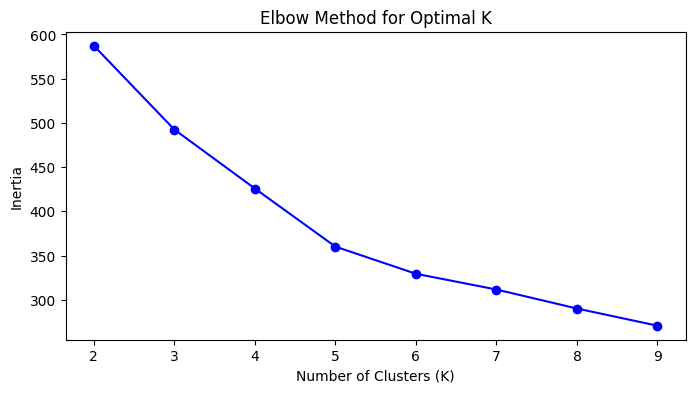

In [21]:
inertias = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [ ]:
## K-Means Clustering


In [29]:
# Choose K based on elbow plot (adjust as needed)
K = 6

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_df['cluster'] = kmeans.fit_predict(X)

print(cluster_df['cluster'].value_counts().sort_index())


cluster
0    27
1    16
2    20
3    29
4    29
5    14
Name: count, dtype: int64


# Cluster profiles: mean of each feature per cluster


In [33]:
cluster_profiles = cluster_df.groupby('cluster')[feature_cols].mean()
cluster_profiles

,avg_boardings,avg_load,avg_reliability,median_income,pct_nonwhite,pct_no_vehicle,pct_poverty
cluster,,,,,,,
0,0.346884,6.810452,0.602118,114437.103424,0.331710,0.111158,0.084891
1,0.702745,8.200819,0.593519,70782.064636,0.706256,0.385249,0.252715
2,0.854380,8.540819,0.688767,118076.455725,0.378779,0.325364,0.138465
3,0.574085,10.150123,0.632056,88789.490087,0.561150,0.164717,0.126987
4,0.442861,6.688754,0.707720,129664.833554,0.316670,0.155263,0.082306
5,1.187189,13.264227,0.755676,71982.399804,0.718009,0.340553,0.219637


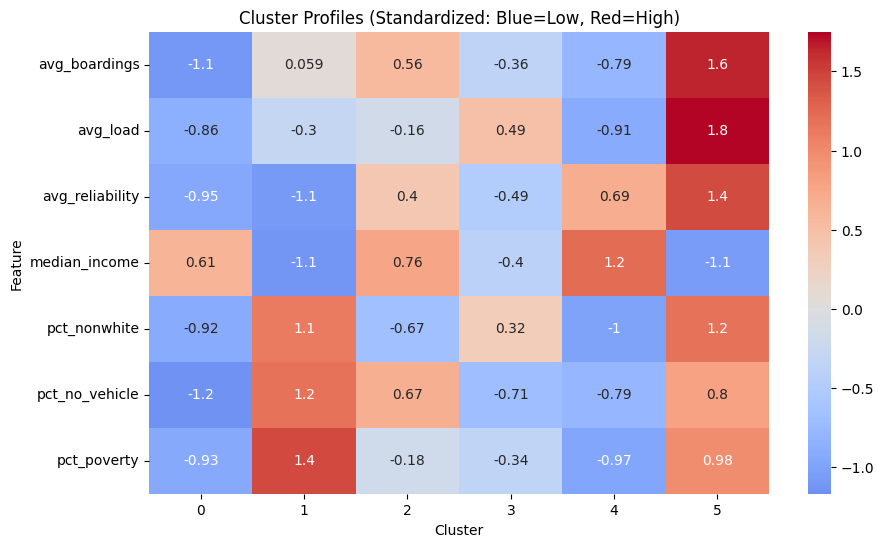

In [34]:
# Visualize cluster profiles
# Note: Values show deviation from mean across clusters (not good/bad)
cluster_profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles_norm.T, annot=True, cmap='coolwarm', center=0)
plt.title('Cluster Profiles (Standardized: Blue=Low, Red=High)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()


In [ ]:
## Identify Underserved Clusters


In [36]:
# Which cluster has lowest reliability + high minority % + high poverty?
# Higher rank = more concerning for that factor
cluster_profiles['ridership_rank'] = cluster_profiles['avg_boardings'].rank(ascending=True)  # High ridership = high rank
cluster_profiles['reliability_rank'] = cluster_profiles['avg_reliability'].rank(ascending=False)  # Low reliability = high rank
cluster_profiles['minority_rank'] = cluster_profiles['pct_nonwhite'].rank(ascending=True)  # High minority = high rank
cluster_profiles['poverty_rank'] = cluster_profiles['pct_poverty'].rank(ascending=True)  # High poverty = high rank
cluster_profiles['underserved_score'] = (cluster_profiles['ridership_rank'] +
                                          cluster_profiles['reliability_rank'] +
                                          cluster_profiles['minority_rank'] +
                                          cluster_profiles['poverty_rank'])

print("Cluster rankings (higher underserved_score = more concerning):")
cluster_profiles.sort_values('underserved_score', ascending=False)


Cluster rankings (higher underserved_score = more concerning):


,avg_boardings,avg_load,avg_reliability,median_income,pct_nonwhite,pct_no_vehicle,pct_poverty,ridership_rank,reliability_rank,minority_rank,poverty_rank,underserved_score
cluster,,,,,,,,,,,,
1,0.702745,8.200819,0.593519,70782.064636,0.706256,0.385249,0.252715,4.0,6.0,5.0,6.0,21.0
5,1.187189,13.264227,0.755676,71982.399804,0.718009,0.340553,0.219637,6.0,1.0,6.0,5.0,18.0
2,0.854380,8.540819,0.688767,118076.455725,0.378779,0.325364,0.138465,5.0,3.0,3.0,4.0,15.0
3,0.574085,10.150123,0.632056,88789.490087,0.561150,0.164717,0.126987,3.0,4.0,4.0,3.0,14.0
0,0.346884,6.810452,0.602118,114437.103424,0.331710,0.111158,0.084891,1.0,5.0,2.0,2.0,10.0
4,0.442861,6.688754,0.707720,129664.833554,0.316670,0.155263,0.082306,2.0,2.0,1.0,1.0,6.0


In [37]:
# List routes in most underserved cluster
worst_cluster = cluster_profiles['underserved_score'].idxmax()
underserved_routes = cluster_df[cluster_df['cluster'] == worst_cluster]['route_id'].tolist()

print(f"\nRoutes in most underserved cluster (Cluster {worst_cluster}):")
print(underserved_routes)



Routes in most underserved cluster (Cluster 1):
['112', '114', '14', '17', '171', '19', '26', '29', '41', '42', '43', '44', '45', '47', '55', '8']


## Hierarchical Clustering (Dendrogram)


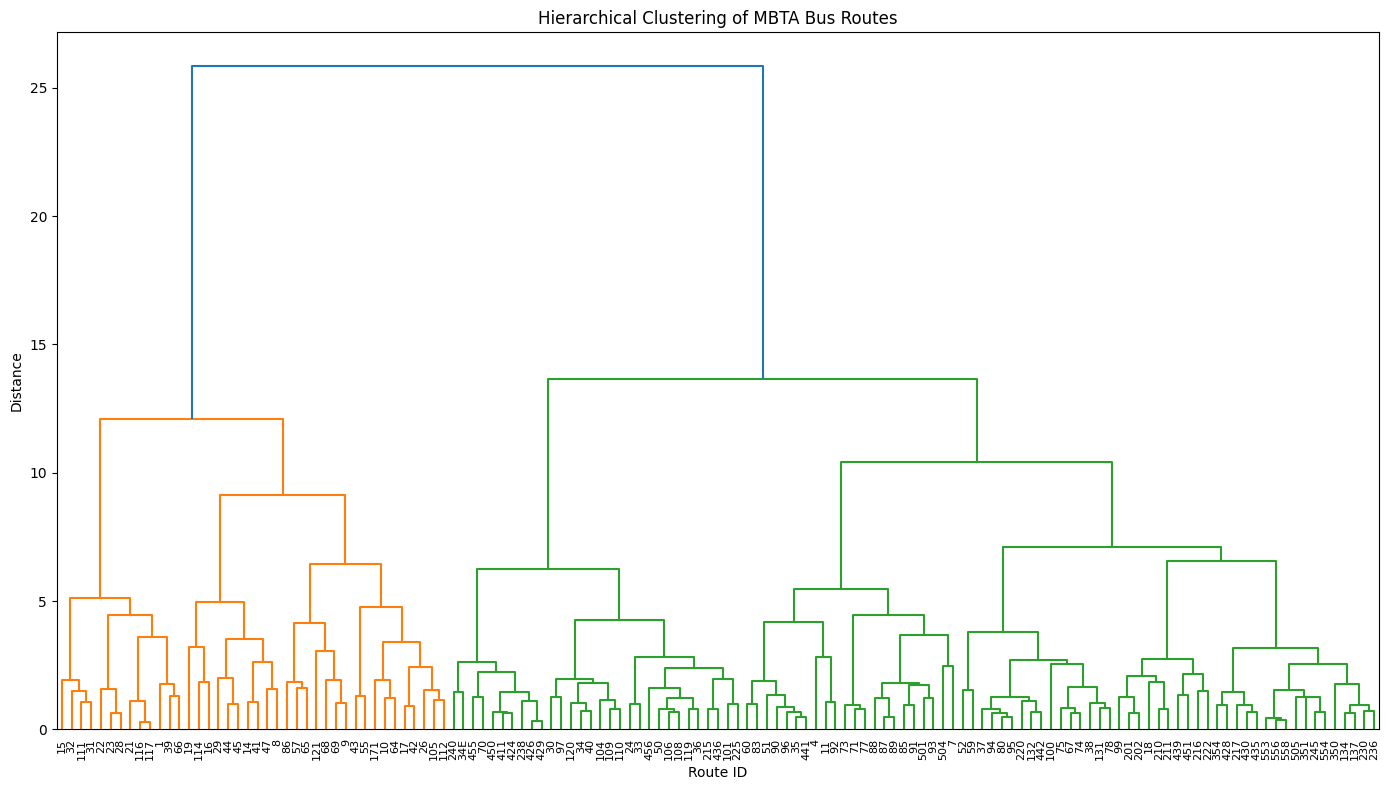

In [38]:
Z = linkage(X, method='ward')

plt.figure(figsize=(14, 8))
dendrogram(Z, labels=cluster_df['route_id'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering of MBTA Bus Routes')
plt.xlabel('Route ID')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


## Scatter Plot: Reliability vs % Non-white by Cluster


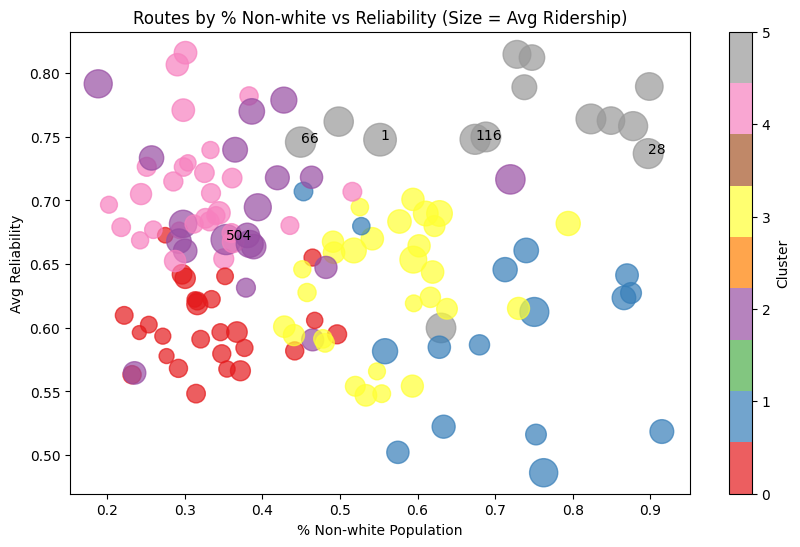

In [39]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    cluster_df['pct_nonwhite'],
    cluster_df['avg_reliability'],
    c=cluster_df['cluster'],
    cmap='Set1',
    alpha=0.7,
    s=cluster_df['avg_boardings'] / cluster_df['avg_boardings'].max() * 500 + 50
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('% Non-white Population')
plt.ylabel('Avg Reliability')
plt.title('Routes by % Non-white vs Reliability (Size = Avg Ridership)')

# Label some key routes
for idx, row in cluster_df.nlargest(5, 'avg_boardings').iterrows():
    plt.annotate(row['route_id'], (row['pct_nonwhite'], row['avg_reliability']))

plt.show()


## Summary


In [40]:
summary = cluster_df.groupby('cluster').agg({
    'route_id': 'count',
    'avg_boardings': 'mean',
    'avg_reliability': 'mean',
    'pct_nonwhite': 'mean',
    'pct_no_vehicle': 'mean',
    'pct_poverty': 'mean',
    'median_income': 'mean'
}).round(3)
summary.columns = ['num_routes', 'avg_boardings', 'avg_reliability', 'avg_pct_nonwhite', 'avg_pct_no_vehicle', 'avg_pct_poverty', 'avg_income']
summary


,num_routes,avg_boardings,avg_reliability,avg_pct_nonwhite,avg_pct_no_vehicle,avg_pct_poverty,avg_income
cluster,,,,,,,
0,27,0.347,0.602,0.332,0.111,0.085,114437.103
1,16,0.703,0.594,0.706,0.385,0.253,70782.065
2,20,0.854,0.689,0.379,0.325,0.138,118076.456
3,29,0.574,0.632,0.561,0.165,0.127,88789.490
4,29,0.443,0.708,0.317,0.155,0.082,129664.834
5,14,1.187,0.756,0.718,0.341,0.220,71982.400
